<a href="https://colab.research.google.com/github/lisphilar/covid19-sir/blob/master/example/02_data_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data engineering
With [Data preparation tutorial](https://github.com/lisphilar/covid19-sir/blob/master/example/01_data_preparation.ipynb), we prepared datasets (geospatial time-series data) to analyze.  As the next step of data engineering, we will perform the followings here.

1. Data cleaning
2. Data transformation
3. Arithmetic operations
4. EDA at a geospatial layer
5. Data subsetting for a location and data complement
6. EDA of subset

Note that EDA = explanatory data analysis

In [79]:
from pprint import pprint
try:
    import covsirphy as cs
except ImportError:
    !pip install --upgrade "git+https://github.com/lisphilar/covid19-sir.git#egg=covsirphy" -qq
    import covsirphy as cs
import numpy as np
cs.__version__

'2.24.0-xi'

We will use the recommended datasets at country-level data as an example.

In [80]:
eng = cs.DataEngineer()
eng.download()
eng.all().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208779 entries, 0 to 208778
Data columns (total 36 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ISO3                                 208779 non-null  category      
 1   Province                             208779 non-null  category      
 2   City                                 208779 non-null  category      
 3   Date                                 208779 non-null  datetime64[ns]
 4   Cancel_events                        165469 non-null  object        
 5   Confirmed                            189232 non-null  object        
 6   Contact_tracing                      165402 non-null  object        
 7   Country                              206130 non-null  string        
 8   Fatal                                172850 non-null  object        
 9   Gatherings_restrictions              165465 non-null  object        
 

## 1. Data cleaning
`DataEngineer().clean()` performs the following data cleaning functionalities. By applying a list of strings to `kinds` argument (eg. `kinds=["resample"]`), we can specify the clening method(s).


- "convert_date": Convert dtype of date column to pandas.Timestamp.
- "resample": Resample records with dates.
- "fillna": Fill NA values with '-' (layers) and the previous values and 0.

In [81]:
eng.clean()
eng.all().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208844 entries, 0 to 208843
Data columns (total 36 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ISO3                                 208844 non-null  category      
 1   Province                             208844 non-null  category      
 2   City                                 208844 non-null  category      
 3   Date                                 208844 non-null  datetime64[ns]
 4   Cancel_events                        208844 non-null  Int64         
 5   Confirmed                            208844 non-null  Int64         
 6   Contact_tracing                      208844 non-null  Int64         
 7   Country                              208844 non-null  object        
 8   Fatal                                208844 non-null  Int64         
 9   Gatherings_restrictions              208844 non-null  Int64         
 

## 2. Data transforamtion
Transform all registered data, calculating the number of susceptible and infected cases. This is required to anlyse real data with SIR-derived models.

- Susceptible = Population - Confirmed
- Infected = Confirmed - Fatal - Recovered

In [82]:
main_variables = ["Population", "Susceptible", "Confirmed", "Infected", "Fatal", "Recovered"]

In [83]:
eng.transform()
eng.all(variables=main_variables).tail()

,ISO3,Province,City,Date,Population,Susceptible,Confirmed,Infected,Fatal,Recovered
208839,ZWE,-,-,2022-07-22,14439018,14182801,256217,167653,5570,82994
208840,ZWE,-,-,2022-07-23,14439018,14182772,256246,167680,5572,82994
208841,ZWE,-,-,2022-07-24,14439018,14182764,256254,167688,5572,82994
208842,ZWE,-,-,2022-07-25,14439018,14182748,256270,167704,5572,82994
208843,ZWE,-,-,2022-07-26,14439018,14182748,256270,167704,5572,82994


Recalculation of "Population" and "Confirmed" can be performed with `DataEngineer().inverse_transform()`, if necessary. (No impact with this example data.)

In [84]:
eng.inverse_transform()
eng.all(variables=main_variables).tail()

,ISO3,Province,City,Date,Population,Susceptible,Confirmed,Infected,Fatal,Recovered
208839,ZWE,-,-,2022-07-22,14439018,14182801,256217,167653,5570,82994
208840,ZWE,-,-,2022-07-23,14439018,14182772,256246,167680,5572,82994
208841,ZWE,-,-,2022-07-24,14439018,14182764,256254,167688,5572,82994
208842,ZWE,-,-,2022-07-25,14439018,14182748,256270,167704,5572,82994
208843,ZWE,-,-,2022-07-26,14439018,14182748,256270,167704,5572,82994


## 3. Arithmetic operations
We can perform arithmetic operations to add new columns.

- `.diff(column, suffix="_diff", freq="D")`: Calculate daily new cases with "f(x>0) = F(x) - F(x-1), x(0) = 0 when F is cumulative numbers".
- `.add(columns, new=None, fill_value=0)`: Calculate element-wise addition with pandas.DataFrame.sum(axis=1), X1 + X2 + X3 +...
- `.mul(columns, new=None, fill_value=0)`: Calculate element-wise multiplication with pandas.DataFrame.product(axis=1), X1 * X2 * X3 *...
- `.sub(minuend, subtrahend, new=None, fill_value=0)`: Calculate element-wise subtraction with pandas.Series.sub(), minuend - subtrahend.
- `.div(columns, new=None, fill_value=0)`: Calculate element-wise floating division with pandas.Series.div(), numerator / denominator.
- `.assign(**kwargs))`: Assign a new column with pandas.DataFrame.assign().


In [85]:
# Diff
eng.diff(column="Confirmed", suffix="_diff", freq="D")
eng.all(variables=["Confirmed", "Confirmed_diff"]).tail()

,ISO3,Province,City,Date,Confirmed,Confirmed_diff
208839,ZWE,-,-,2022-07-22,256217,0
208840,ZWE,-,-,2022-07-23,256246,29
208841,ZWE,-,-,2022-07-24,256254,8
208842,ZWE,-,-,2022-07-25,256270,16
208843,ZWE,-,-,2022-07-26,256270,0


In [86]:
# Addition
eng.add(columns=["Fatal", "Recovered"])
eng.all(variables=["Fatal", "Recovered", "Fatal+Recovered"]).tail()

,ISO3,Province,City,Date,Fatal,Recovered,Fatal+Recovered
208839,ZWE,-,-,2022-07-22,5570,82994,88564
208840,ZWE,-,-,2022-07-23,5572,82994,88566
208841,ZWE,-,-,2022-07-24,5572,82994,88566
208842,ZWE,-,-,2022-07-25,5572,82994,88566
208843,ZWE,-,-,2022-07-26,5572,82994,88566


In [87]:
# Multiplication
eng.mul(columns=["Confirmed", "Recovered"])
eng.all(variables=["Confirmed", "Recovered", "Confirmed*Recovered"]).tail()

,ISO3,Province,City,Date,Confirmed,Recovered,Confirmed*Recovered
208839,ZWE,-,-,2022-07-22,256217,82994,21264473698
208840,ZWE,-,-,2022-07-23,256246,82994,21266880524
208841,ZWE,-,-,2022-07-24,256254,82994,21267544476
208842,ZWE,-,-,2022-07-25,256270,82994,21268872380
208843,ZWE,-,-,2022-07-26,256270,82994,21268872380


In [88]:
# Division
eng.div(numerator="Confirmed", denominator="Tests", new="Positive_rate")
# Assignment of new a new column
eng.assign(**{"Positive_rate_%": lambda x: x["Positive_rate"] * 100})
eng.all(variables=["Tests", "Confirmed", "Positive_rate_%"]).tail()

,ISO3,Province,City,Date,Tests,Confirmed,Positive_rate_%
208839,ZWE,-,-,2022-07-22,2379907,256217,10.765841
208840,ZWE,-,-,2022-07-23,2379907,256246,10.767059
208841,ZWE,-,-,2022-07-24,2379907,256254,10.767396
208842,ZWE,-,-,2022-07-25,2379907,256270,10.768068
208843,ZWE,-,-,2022-07-26,2379907,256270,10.768068


## 4. EDA at a geospatial layer
`DataEngineer().layer()` returns the data at the selected layer in the date range.

Arguments:
- geo (tuple(list[str] or tuple(str) or str) or str or None): location names to specify the layer or None (the top level)
- start_date (str or None): start date, like 22Jan2020
- end_date (str or None): end date, like 01Feb2020
- variables (list[str] or None): list of variables to add or None (all available columns)

In [89]:
eng.layer().tail()

,ISO3,Province,City,Date,Cancel_events,Confirmed,Confirmed*Recovered,Confirmed_diff,Contact_tracing,Country,...,Tests,Transport_closing,Vaccinated_1st,Vaccinated_2nd,Vaccinated_3rd,Vaccinated_full,Vaccinated_once,Vaccinations,Vaccinations_boosters,Workplace_closing
208839,ZWE,-,-,2022-07-22,1,256217,21264473698,0,1,Zimbabwe,...,2379907,0,0,0,0,4637374,6331851,12045572,1076347,1
208840,ZWE,-,-,2022-07-23,1,256246,21266880524,29,1,Zimbabwe,...,2379907,0,0,0,0,4637374,6331851,12045572,1076347,1
208841,ZWE,-,-,2022-07-24,1,256254,21267544476,8,1,Zimbabwe,...,2379907,0,0,0,0,4637374,6331851,12045572,1076347,1
208842,ZWE,-,-,2022-07-25,1,256270,21268872380,16,1,Zimbabwe,...,2379907,0,0,0,0,4637374,6331851,12045572,1076347,1
208843,ZWE,-,-,2022-07-26,1,256270,21268872380,0,1,Zimbabwe,...,2379907,0,0,0,0,4637374,6331851,12045572,1076347,1


This dataset has only country-level data and `geo` should be country name.

 We can select the followings as `geo` argument for EDA at a geospatial layer when we have adequate data.
- When `geo=None` or `geo=(None,)`, returns country-level data, assuming we have country/province/city as layers here.
- When `geo=("Japan",)` or `geo="Japan"`, returns province-level data in Japan.
- When `geo=(["Japan", "UK"],)`, returns province-level data in Japan and UK.
- When `geo=("Japan", "Kanagawa")`, returns city-level data in Kanagawa/Japan.
- When `geo=("Japan", ["Tokyo", "Kanagawa"])`, returns city-level data in Tokyo/Japan and Kanagawa/Japan.

Addtionally, we can create a choropleth map with a data at a geospatial layer on a date.

arguments of `DataEngineer().choropleth()`:
- geo (tuple(list[str] or tuple(str) or str) or str or None): location names to specify the layer or None (the top level)
- variable (str): variable name to show
- on (str or None): the date, like 22Jan2020, or None (the last date of each location)
- title (str): title of the map
- filename (str or None): filename to save the figure or None (display)
- logscale (bool): whether convert the value to log10 scale values or not
- directory (str): directory to save GeoJSON file of "Natural Earth" GitHub repository
- natural_earth (str or None): title of GeoJSON file (without extension) of "Natural Earth" GitHub repository or None (automatically determined)
- **kwargs: keyword arguments of the following classes and methods.
    - matplotlib.pyplot.savefig(), matplotlib.pyplot.legend(), and
    - pandas.DataFrame.plot()

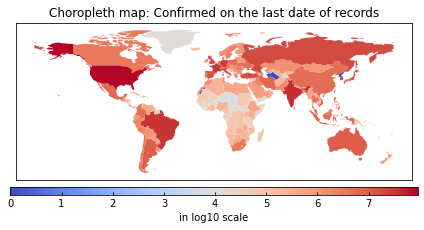

In [90]:
eng.choropleth(geo=None, variable="Confirmed", title="Choropleth map: Confirmed on the last date of records", filename=None)

## 5. Data subsetting for a location and data complement
The dataset is a geospatial time-series data. By selecting a location, the dataset will be converted to a time-series data, which is easier to analyze.

### 5.1 Subsetting
We will create a subset for selected location (eg. country, province/prefecture/state, city). Because the loaded dataset has country-level data, total values in United Kingdom (UK) on dates will be created here as an example.

Arguements of `DataEngineeer().subset()`:
- geo (tuple(list[str] or tuple(str) or str) or str or None): location names to filter or None (total at the top level)
- start_date (str or None): start date, like 22Jan2020
- end_date (str or None): end date, like 01Feb2020
- variables (list[str] or None): list of variables to add or None (all available columns)
- complement (bool): whether perform data complement or not, True as default
- **Kwargs: keyword arguments for complement and default values
    - recovery_period (int): expected value of recovery period [days], 17
    - interval (int): expected update interval of the number of recovered cases [days], 2
    - max_ignored (int): Max number of recovered cases to be ignored [cases], 100
    - max_ending_unupdated (int): Max number of days to apply full complement, where max recovered cases are not updated [days], 14
    - upper_limit_days (int): maximum number of valid partial recovery periods [days], 90
    - lower_limit_days (int): minimum number of valid partial recovery periods [days], 7
    - upper_percentage (float): fraction of partial recovery periods with value greater than upper_limit_days, 0.5
    - lower_percentage (float): fraction of partial recovery periods with value less than lower_limit_days, 0.5

NOTE:  
We can select the followings as `geo` argument for subsetting when we have adequate data.
- When `geo=None` or `geo=(None,)`, returns total values of all country-level data, assuming we have country/province/city as layers here.
- When `geo=("Japan",)` or `geo="Japan"`, returns country-level data in Japan.
- When `geo=(["Japan", "UK"],)`, returns country-level data of Japan and UK.
- When `geo=("Japan", "Tokyo")`, returns province-level data of Tokyo/Japan.
- When `geo=("Japan", ["Tokyo", "Kanagawa"])`, returns total values of province-level data of Tokyo/Japan and Kanagawa/Japan.
- When `geo=("Japan", "Kanagawa", "Yokohama")`, returns city-level data of Yokohama/Kanagawa/Japan.
- When `geo=(("Japan", "Kanagawa", ["Yokohama", "Kawasaki"])`, returns total values of city-level data of Yokohama/Kanagawa/Japan and Kawasaki/Kanagawa/Japan.



{}


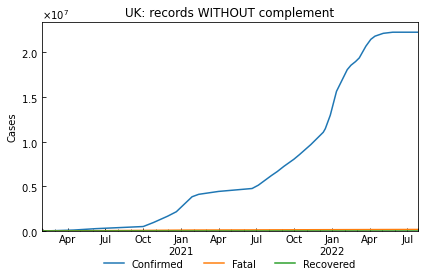

In [91]:
# Without complement
without_df, status, status_dict = eng.subset(geo="UK", complement=False)
print(f"{status}\n")
pprint(status_dict)
cs.line_plot(without_df[["Confirmed", "Fatal", "Recovered"]], title="UK: records WITHOUT complement")

monotonic increasing complemented confirmed data and 
monotonic increasing complemented fatal data and 
partially complemented recovered data

{'Full_recovered': False,
 'Monotonic_confirmed': True,
 'Monotonic_fatal': True,
 'Monotonic_recovered': True,
 'Partial_recovered': True}


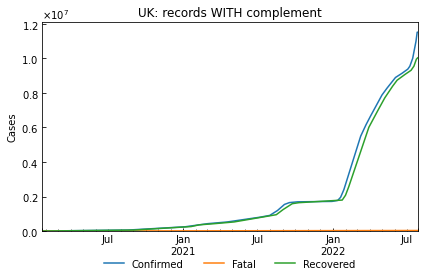

In [92]:
# With complement (default)
with_df, status, status_dict = eng.subset(geo="Japan", complement=True)
print(f"{status}\n")
pprint(status_dict)
cs.line_plot(with_df[["Confirmed", "Fatal", "Recovered"]], title="UK: records WITH complement")

### 5.2 Details of data comlement

When `complement=True` (default), data complement will be performed for confirmed/fatal/recovered data. This may be required for analysis because reported cumulative values sometimes show decreasing by changing accidentally for an example. Addtionally, some countires, including UK, do not report the number of recovered cases.

The possible kinds of complement for each country are the following:

- "Monotonic_confirmed/fatal/recovered" (monotonic increasing complement) Force the variable show monotonic increasing.
- "Full_recovered" (full complement of recovered data) Estimate the number of recovered cases using the value of estimated average recovery period.
- "Partial_recovered" (partial complement of recovered data) When recovered values are not updated for some days, extrapolate the values.


### 5.3 Recovery period
What is "recovery period"?  
We defined "recovery period" as the time period between case confirmation and recovery (as it is subjectively defined per country). We can estimate the mode value of recovery period with class method `DataEngineer.recovery_period(data)`.

In [93]:
jpn_df, *_ = eng.subset(geo="Japan", variables=["Confirmed", "Fatal", "Recovered"], complement=False)
recovery_period = cs.DataEngineer.recovery_period(data=jpn_df)
print(f"Mode value of recovery period in Japan: {recovery_period} [days]")

Mode value of recovery period in Japan: 10 [days]


Details of recovery period calculation:

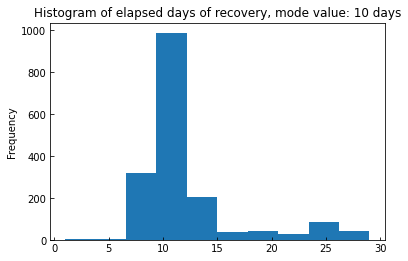

In [94]:
df = jpn_df.resample("D").sum()
df["diff"] = df["Confirmed"] - df["Fatal"]
df = df.loc[:, ["diff", "Recovered"]].unstack().reset_index()
df.columns = ["Variable", "Date", "Number"]
df["Days"] = (df["Date"] - df["Date"].min()).dt.days
df = df.pivot_table(values="Days", index="Number", columns="Variable")
df = df.interpolate(limit_area="inside").dropna().astype(np.int64)
df["Elapsed"] = df["Recovered"] - df["diff"]
df = df.loc[df["Elapsed"] > 0]
# Calculate mode value
mode_value = round(df["Elapsed"].mode().mean())
df["Elapsed"].plot.hist(title=f"Histogram of elapsed days of recovery, mode value: {mode_value} days");

### 5.4 Alias of subsets
We can register alias names of subsets with `DataEngineer().subset_alias()`.

Arguments:  
- alias (str or None): alias name or None (list-up alias names)
- update (bool): force updating the alias when @alias is not None
- **kwargs: keyword arguments of covsirphy.DataEngineer().subset()

In [95]:
# Register
sub1, *_ = eng.subset_alias(alias="UK_with", geo="UK", complement=True)
# Retrieve with alias
sub2, *_ = eng.subset_alias(alias="UK_with")
# Comparison
sub1.equals(sub2)

True

## 7. EDA of subset
With explanatory data analysis, we will get the figure of datasets.

### 7.1 Alias of variables
We can specify varialbles with alias. For example, "CIFR" is equivalent to list `['Confirmed', 'Infected', 'Fatal', 'Recovered']`.

In [96]:
eng.subset(geo="Japan", variables="CIFR")[0].tail()

,Confirmed,Infected,Fatal,Recovered
Date,,,,
2022-07-23,10981802,1085567,31799,9864436
2022-07-24,11388696,1405698,31901,9951097
2022-07-25,11515272,1454421,31949,10028902
2022-07-26,11515272,1454421,31949,10028902
2022-07-27,11515272,1454421,31949,10028902


All aliases can be checked with `DataEngineer().variables_alias()`.

In [97]:
eng.variables_alias()

{'C': ['Confirmed'],
 'CFR': ['Confirmed', 'Fatal', 'Recovered'],
 'CIFR': ['Confirmed', 'Infected', 'Fatal', 'Recovered'],
 'CR': ['Confirmed', 'Recovered'],
 'F': ['Fatal'],
 'I': ['Infected'],
 'N': ['Population'],
 'R': ['Recovered'],
 'S': ['Susceptible'],
 'T': ['Tests']}

We can register new alias "p" with `["Tests", "Confirmed", "Positive_rate_%"]` as an example.

In [98]:
# Register new alias
eng.variables_alias(alias="p", variables=["Tests", "Confirmed", "Positive_rate_%"])
# Check the contents of an alias
eng.variables_alias(alias="p")
# Subsetting with the varialble alias
eng.subset_alias(alias="jp", geo="Japan", variables="p")[0].tail()

,Tests,Confirmed,Positive_rate_%
Date,,,
2022-07-23,60384408,10981802,18.186486
2022-07-24,60594911,11388696,18.794806
2022-07-25,60736524,11515272,18.959386
2022-07-26,60736524,11515272,18.959386
2022-07-27,60736524,11515272,18.959386


### 7.2 Line plot
Show data with line plot. We can selct function `line_plot` or class `LinePlot`.

In [99]:
line_df, *_ = eng.subset_alias(alias="jp")

With function:

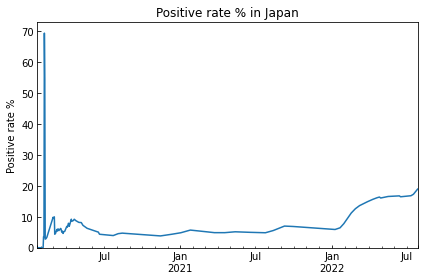

In [100]:
cs.line_plot(
    line_df["Positive_rate_%"],
    title="Positive rate % in Japan",
    ylabel="Positive rate %",
    math_scale=False,
    show_legend=False,
    filename=None,
)

With class:

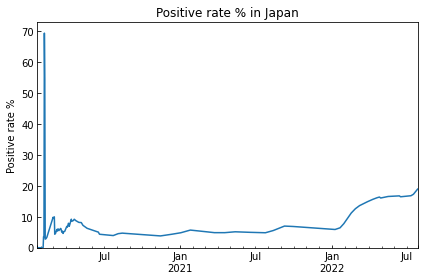

In [101]:
with cs.LinePlot(filename=None) as lp:
    lp.plot(line_df["Positive_rate_%"])
    lp.title = "Positive rate % in Japan"
    lp.x_axis(xlabel=None)
    lp.y_axis(ylabel="Positive rate %", math_scale=False)
    lp.legend_hide()

### 7.3 Scatter plot
Show data with scatter plot. We can selct function `scatter_plot` or class `ScatterPlot`.

In [102]:
sc_df, *_ = eng.subset_alias(alias="jp")
sc_df.rename(columns={"Tests": "x", "Confirmed": "y"}, inplace=True)

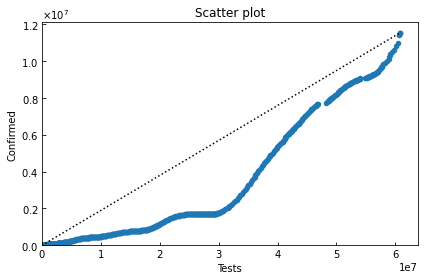

In [103]:
cs.scatter_plot(
    sc_df,
    title="Scatter plot",
    xlabel="Tests", xlim=(0, None),
    ylabel="Confirmed",
    filename=None,
)

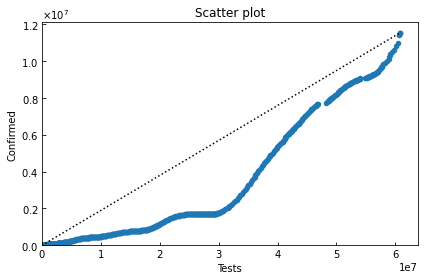

In [104]:
with cs.ScatterPlot(filename=None) as sp:
    sp.plot(sc_df)
    sp.title = "Scatter plot"
    sp.x_axis(xlabel="Tests", xlim=(0, None))
    sp.y_axis(ylabel="Confirmed")
    sp.line_straight(p1=(0, 0), p2=(max(sc_df["x"]), max(sc_df["y"])))

Thank you!